In [ ]:
# ===================================================================
# Cellule 1 : Import des bibliothèques et configuration initiale
# ===================================================================
# Cette cellule est dédiée à l'importation de toutes les dépendances nécessaires
# au projet et à la configuration de l'environnement de travail.

import os
import gc # Garbage Collector, utile pour gérer la mémoire dans les longs processus
import torch # La bibliothèque principale pour le deep learning
import numpy as np # Pour les opérations numériques, souvent utilisé par d'autres bibliothèques
import pandas as pd # Pour la manipulation et l'analyse de données tabulaires
import matplotlib.pyplot as plt # Pour la création de graphiques et de visualisations
import seaborn as sns # Une surcouche de Matplotlib pour des graphiques plus esthétiques
import psutil # Pour monitorer l'utilisation des ressources système (CPU, RAM)
from sklearn.manifold import TSNE # Pour la réduction de dimensionnalité et la visualisation
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve # Métriques d'évaluation
from io import StringIO
import json
from datetime import datetime

# --- Import de PyTorch Geometric (PyG) ---
# PyG est une bibliothèque spécialisée pour le Deep Learning sur les graphes.
# On encapsule cet import dans un bloc try-except pour s'assurer que la bibliothèque
# est bien installée, et guider l'utilisateur si ce n'est pas le cas.
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv, VGAE
    from torch_geometric.utils import train_test_split_edges, negative_sampling
    import torch.nn.functional as F
except ImportError:
    print("ERREUR: PyTorch Geometric n'est pas installé.")
    print("Veuillez l'installer, par exemple avec : pip install torch-geometric")
    # Pour Colab, des commandes plus spécifiques peuvent être nécessaires.
    exit()

# --- Configuration de l'affichage et des visualisations ---
# On active l'affichage des graphiques directement dans le notebook
%matplotlib inline
# On configure pandas pour afficher toutes les colonnes d'un DataFrame
pd.set_option('display.max_columns', None)
# On choisit un style visuel pour les graphiques
plt.style.use('ggplot')
# On définit une taille par défaut pour les figures Matplotlib
plt.rcParams['figure.figsize'] = (14, 8)

# --- Définition de l'appareil (Device) ---
# Le Deep Learning est beaucoup plus rapide sur GPU. Cette ligne vérifie si un GPU
# compatible CUDA est disponible et le sélectionne. Sinon, elle se rabat sur le CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cpu


In [ ]:
# ===================================================================
# Cellule 2 : Chargement et préparation des nouvelles données (v4 avec comportement)
# ===================================================================
# Cette cellule charge le graphe pré-construit et les mappings de nœuds.
# Ces fichiers sont générés par les notebooks 'pretraitement.ipynb' et 'construction_graphe.ipynb'.

# Noms des fichiers de la version 4 avec caractéristiques comportementales
graph_path = 'construction/credential_stuffing_graph_v4.pt'
mapping_path = 'construction/node_mapping_v4.pt'

# Vérification de l'existence des fichiers pour éviter les erreurs
if not os.path.exists(graph_path) or not os.path.exists(mapping_path):
    raise FileNotFoundError(
        "Fichiers de graphe V4 non trouvés. "
        "Assurez-vous d'avoir exécuté 'pretraitement.ipynb' et 'construction_graphe.ipynb' avec les dernières modifications."
    )

# --- Chargement des données ---
# On charge l'objet Data de PyTorch Geometric, qui contient la structure du graphe et les caractéristiques des nœuds.
# Le mapping permet de faire le lien entre les identifiants des nœuds (IP, user) et leurs indices dans les tenseurs.
data = torch.load(graph_path, weights_only=False)
idx_to_node = torch.load(mapping_path, weights_only=False)
node_to_idx = {v: k for k, v in idx_to_node.items()}

print("--- Graphe V4 chargé (avec caractéristiques comportementales) ---")
print(data)
print(f"Nombre de caractéristiques par nœud : {data.num_node_features}")

# --- Normalisation des caractéristiques ---
# La normalisation est cruciale pour que le modèle de deep learning converge bien.
# Au lieu d'une normalisation Z-score, on utilise ici une normalisation Min-Max.
# Cela ramène toutes les valeurs des caractéristiques dans l'intervalle [0, 1].
# L'ajout de 1e-8 évite les divisions par zéro si une caractéristique est constante.
x_min = data.x.min(dim=0, keepdim=True).values
x_max = data.x.max(dim=0, keepdim=True).values
data.x = (data.x - x_min) / (x_max - x_min + 1e-8)

# Remplacement des potentiels NaN (Not a Number) par 0 après la normalisation.
data.x = torch.nan_to_num(data.x, nan=0.0)
print("\nCaractéristiques des nœuds normalisées (Min-Max).")


# --- Transfert des données sur le bon appareil (CPU/GPU) ---
data = data.to(device)
print(f"Données déplacées vers '{device}'.")

# --- Création d'un DataFrame pour l'analyse exploratoire ---
# Bien que le modèle travaille avec des tenseurs, il est souvent plus pratique
# d'utiliser un DataFrame pandas pour inspecter les données.
feature_names = [
    'is_ip', 'is_user', 'degree', 'total_attempts', 
    'failure_rate', 'specific_feature', 
    'num_countries', 'num_cities',
    'conn_freq', 'ua_diversity' # NOUVEAU
]
node_features_df = pd.DataFrame(data.x.cpu().numpy(), columns=feature_names)
node_features_df['node_id'] = node_features_df.index.map(idx_to_node.get)
node_features_df = node_features_df.set_index('node_id')

print("\nAperçu du DataFrame des caractéristiques (avec comportement) :")
display(node_features_df.head())

--- Graphe V4 chargé (avec caractéristiques comportementales) ---
Data(x=[14671, 10], edge_index=[2, 32774], edge_attr=[32774, 3])
Nombre de caractéristiques par nœud : 10

Caractéristiques des nœuds normalisées (Min-Max).
Données déplacées vers 'cpu'.

Aperçu du DataFrame des caractéristiques (avec comportement) :


,is_ip,is_user,degree,total_attempts,failure_rate,specific_feature,num_countries,num_cities,conn_freq,ua_diversity
node_id,,,,,,,,,,
674a135355e8b1e1e55b932e176415c3c85290676ff72ce8a7d14db986becc84,1.0,0.0,0.000000,0.000308,0.0,0.000000,0.0,0.0,1.000000,0.0
cfd5065ab4d87895601e26bd782055667e7b9d033424b6707a5d3f68cbc82791,1.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.261724,0.0
fe14787607e69d705c79db451fa77bbe721ac9f1c55b6fc88b7427bf3b32a792,1.0,0.0,0.521959,0.421572,0.0,0.521959,0.0,0.0,0.130202,0.0
95b951dd7f08f826d2d37ae08e55d3ae1495a34296b14ef80af0a0a70b6e0faa,1.0,0.0,0.000000,0.000924,0.0,0.000000,0.0,0.0,0.911194,0.0
87d85321a85e642c79f0959209819f3b67002c2eda400ac6d8eee2d58f0581d1,1.0,0.0,0.979013,0.985516,0.0,0.979013,0.0,0.0,0.258987,0.0


In [ ]:
# ===================================================================
# Cellule 3 : Définition des classes de modèles (GAE) - (MODIFIÉE)
# ===================================================================
# Cette cellule définit les architectures des modèles d'encodeur que nous allons utiliser.
# L'encodeur est la partie du GAE (Graph Autoencoder) qui apprend à compresser
# les informations d'un nœud et de son voisinage en un vecteur de faible dimension (embedding).

from torch_geometric.nn import GAE

# --- 1. Encodeur GCN de base ---
# Cet encodeur est simple et direct. Il utilise deux couches de convolution sur graphe (GCNConv).
# La première couche transforme les caractéristiques d'entrée en un espace de dimension cachée.
# La fonction d'activation ReLU introduit de la non-linéarité.
# La deuxième couche transforme l'espace caché en l'espace latent final (embedding z).
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # cached=True est une optimisation pour les graphes qui ne changent pas, ce qui est notre cas.
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        # La méthode forward définit le passage des données à travers le réseau.
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# --- 2. Encodeur GCN amélioré ---
# Cette version ajoute une couche de Dropout entre les deux couches de convolution.
# Le Dropout est une technique de régularisation qui aide à prévenir le surapprentissage (overfitting).
# Pendant l'entraînement, il met aléatoirement à zéro une fraction des neurones, forçant le modèle
# à apprendre des caractéristiques plus robustes.
class ImprovedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.dropout = dropout
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # Le dropout n'est appliqué que pendant la phase d'entraînement (self.training).
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

# Note : Le modèle GAE de PyTorch Geometric inclut un décodeur par défaut (produit scalaire).
# Ce décodeur prend les embeddings (z) de deux nœuds et calcule un score de similarité pour
# prédire l'existence d'une arête entre eux. Nous n'avons donc plus besoin de définir notre propre décodeur.
print("Classes des modèles GAE définies.")

Classes des modèles GAE définies.


In [ ]:
# ===================================================================
# CELLULE 4 : Fonction d'entraînement et d'évaluation (MODIFIÉE pour GAE)
# ===================================================================
# Cette cellule contient les fonctions qui vont gérer le processus d'entraînement
# et d'évaluation de nos modèles GAE.

def train_model(model, train_data, epochs, lr=0.01, weight_decay=1e-5):
    """Fonction générique pour entraîner notre GAE."""
    # Met le modèle en mode entraînement. Cela active des couches comme le Dropout.
    model.train()
    # L'optimiseur Adam est un choix standard et efficace pour de nombreux problèmes de deep learning.
    # `weight_decay` est une forme de régularisation L2 qui pénalise les grands poids pour éviter l'overfitting.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    losses = []
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad() # Réinitialise les gradients à chaque époque
        
        # Étape 1 : Encodage
        # Le modèle encode les caractéristiques (x) et la structure du graphe (train_pos_edge_index)
        # pour produire les vecteurs latents z.
        z = model.encode(train_data.x, train_data.train_pos_edge_index)
        
        # Étape 2 : Calcul de la perte
        # La perte du GAE est l'erreur de reconstruction. Le modèle essaie de reconstruire
        # les arêtes d'entraînement à partir des embeddings z. La fonction `recon_loss` calcule cette erreur.
        loss = model.recon_loss(z, train_data.train_pos_edge_index)
                
        # Étape 3 : Rétropropagation et optimisation
        loss.backward() # Calcule les gradients de la perte par rapport aux poids du modèle.
        optimizer.step() # Met à jour les poids du modèle en utilisant les gradients.
        losses.append(loss.item())
        
        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
    return model, losses

# --- Fonction d'évaluation pour GAE ---
def evaluate_model(model, data):
    """Évalue un modèle GAE sur les ensembles de validation et de test."""
    # Met le modèle en mode évaluation. Cela désactive des couches comme le Dropout.
    model.eval()
    with torch.no_grad(): # Désactive le calcul des gradients pour économiser de la mémoire et du temps
        z = model.encode(data.x, data.train_pos_edge_index)
        
        # --- Évaluation sur l'ensemble de validation ---
        # On décode les scores pour les arêtes positives (réelles) et négatives (factices) de l'ensemble de validation.
        pos_pred_val = model.decode(z, data.val_pos_edge_index)
        neg_pred_val = model.decode(z, data.val_neg_edge_index)
        y_pred_val = torch.cat([pos_pred_val, neg_pred_val]).cpu()
        y_true_val = torch.cat([torch.ones_like(pos_pred_val), torch.zeros_like(neg_pred_val)]).cpu()
        
        # On calcule les métriques AUC (Area Under ROC Curve) et AP (Average Precision).
        val_auc = roc_auc_score(y_true_val, y_pred_val)
        val_ap = average_precision_score(y_true_val, y_pred_val)

        # --- Évaluation sur l'ensemble de test ---
        # On fait de même pour l'ensemble de test.
        pos_pred_test = model.decode(z, data.test_pos_edge_index)
        neg_pred_test = model.decode(z, data.test_neg_edge_index)
        y_pred_test = torch.cat([pos_pred_test, neg_pred_test]).cpu()
        y_true_test = torch.cat([torch.ones_like(pos_pred_test), torch.zeros_like(neg_pred_test)]).cpu()
        
        test_auc = roc_auc_score(y_true_test, y_pred_test)
        test_ap = average_precision_score(y_true_test, y_pred_test)
    
    return val_auc, val_ap, test_auc, test_ap

print("Fonctions d'entraînement et d'évaluation GAE prêtes.")

Fonctions d'entraînement et d'évaluation GAE prêtes.


/Users/ismail/PING14/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 020, Original Model: Loss: 0.8700, Val AUC: 0.8942, Val AP: 0.9433
Epoch 020, Improved Model: Loss: 0.8567, Val AUC: 0.8901, Val AP: 0.9407
Epoch 040, Original Model: Loss: 0.8346, Val AUC: 0.9006, Val AP: 0.9456
Epoch 040, Improved Model: Loss: 0.8351, Val AUC: 0.9043, Val AP: 0.9485
Epoch 040, Original Model: Loss: 0.8346, Val AUC: 0.9006, Val AP: 0.9456
Epoch 040, Improved Model: Loss: 0.8351, Val AUC: 0.9043, Val AP: 0.9485
Epoch 060, Original Model: Loss: 0.8153, Val AUC: 0.9189, Val AP: 0.9558
Epoch 060, Improved Model: Loss: 0.8113, Val AUC: 0.9114, Val AP: 0.9528
Epoch 060, Original Model: Loss: 0.8153, Val AUC: 0.9189, Val AP: 0.9558
Epoch 060, Improved Model: Loss: 0.8113, Val AUC: 0.9114, Val AP: 0.9528
Epoch 080, Original Model: Loss: 0.7960, Val AUC: 0.9248, Val AP: 0.9594
Epoch 080, Improved Model: Loss: 0.8019, Val AUC: 0.9225, Val AP: 0.9586
Epoch 080, Original Model: Loss: 0.7960, Val AUC: 0.9248, Val AP: 0.9594
Epoch 080, Improved Model: Loss: 0.8019, Val AUC: 0

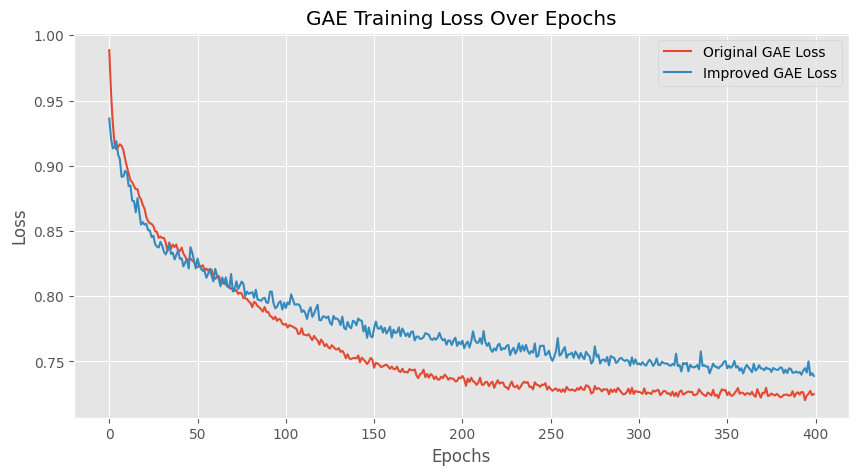

In [ ]:
# ===================================================================
# Cellule 5 : Instanciation, Entraînement et Évaluation (MODIFIÉE pour GAE)
# ===================================================================
# Cette cellule est le cœur de l'expérience. On y instancie les modèles,
# on les entraîne sur les données, et on évalue leurs performances.

from torch_geometric.nn import GAE, GCNConv
from torch_geometric.utils import train_test_split_edges
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

# Redéfinition des classes d'encodeur (par clarté, bien que déjà définies avant)
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

class ImprovedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(ImprovedGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

# --- Définition des hyperparamètres ---
# Ces paramètres contrôlent l'architecture du modèle et le processus d'entraînement.
IN_CHANNELS = data.num_features       # Dimension des caractéristiques d'entrée
HIDDEN_CHANNELS = 128                 # Nombre de neurones dans la couche cachée
LATENT_DIM = 64                       # Dimension de l'espace latent (embedding z)
LEARNING_RATE = 0.001                 # Taux d'apprentissage pour l'optimiseur
EPOCHS = 400                          # Nombre de cycles d'entraînement complets

# --- Division des données ---
# On divise les arêtes du graphe en ensembles d'entraînement, de validation et de test.
# C'est crucial pour évaluer si le modèle généralise bien à des données qu'il n'a jamais vues.
original_edge_index = data.edge_index.clone() # Sauvegarde des arêtes originales pour l'analyse finale
data_split = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.2)

# --- Instanciation des modèles ---
# On crée une instance de chaque modèle GAE : un avec l'encodeur de base, l'autre avec l'encodeur amélioré.
encoder_orig = GCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM)
model_orig = GAE(encoder_orig)

encoder_imp = ImprovedGCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM, dropout=0.5)
model_improved = GAE(encoder_imp)

# On déplace les modèles et les données sur le device sélectionné (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_orig = model_orig.to(device)
model_improved = model_improved.to(device)
x = data_split.x.to(device)
train_pos_edge_index = data_split.train_pos_edge_index.to(device)

# --- Instanciation des Optimiseurs ---
# Chaque modèle a son propre optimiseur pour mettre à jour ses poids.
optimizer_orig = torch.optim.Adam(model_orig.parameters(), lr=LEARNING_RATE)
optimizer_improved = torch.optim.Adam(model_improved.parameters(), lr=LEARNING_RATE)

# --- Fonctions d'entraînement et de test (simplifiées pour la boucle) ---
def train(model, optimizer, train_pos_edge_index):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, pos_edge_index, neg_edge_index):
    model.eval()
    z = model.encode(x, train_pos_edge_index)
    # La méthode `test` de GAE calcule l'AUC et l'AP pour nous.
    return model.test(z, pos_edge_index, neg_edge_index)

# --- Boucle d'entraînement principale ---
losses_orig, losses_imp = [], []
val_auc_history_orig, val_ap_history_orig = [], []
val_auc_history_imp, val_ap_history_imp = [], []

for epoch in range(1, EPOCHS + 1):
    # Entraînement et évaluation du modèle original
    loss_orig = train(model_orig, optimizer_orig, train_pos_edge_index)
    losses_orig.append(loss_orig)
    val_auc_orig, val_ap_orig = test(model_orig, data_split.val_pos_edge_index, data_split.val_neg_edge_index)
    val_auc_history_orig.append(val_auc_orig)
    val_ap_history_orig.append(val_ap_orig)

    # Entraînement et évaluation du modèle amélioré
    loss_imp = train(model_improved, optimizer_improved, train_pos_edge_index)
    losses_imp.append(loss_imp)
    val_auc_imp, val_ap_imp = test(model_improved, data_split.val_pos_edge_index, data_split.val_neg_edge_index)
    val_auc_history_imp.append(val_auc_imp)
    val_ap_history_imp.append(val_ap_imp)

    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Original Model: Loss: {loss_orig:.4f}, Val AUC: {val_auc_orig:.4f}, Val AP: {val_ap_orig:.4f}')
        print(f'Epoch {epoch:03d}, Improved Model: Loss: {loss_imp:.4f}, Val AUC: {val_auc_imp:.4f}, Val AP: {val_ap_imp:.4f}')

# --- Évaluation finale sur l'ensemble de test ---
# C'est la mesure de performance définitive de nos modèles.
test_auc_orig, test_ap_orig = test(model_orig, data_split.test_pos_edge_index, data_split.test_neg_edge_index)
print(f'\nOriginal Model - Test AUC: {test_auc_orig:.4f}, Test AP: {test_ap_orig:.4f}')

test_auc_imp, test_ap_imp = test(model_improved, data_split.test_pos_edge_index, data_split.test_neg_edge_index)
print(f'Improved Model - Test AUC: {test_auc_imp:.4f}, Test AP: {test_ap_imp:.4f}')

# --- Visualisation de la perte ---
# On affiche la courbe de perte pour voir si les modèles ont bien convergé.
plt.figure(figsize=(10, 5))
plt.plot(losses_orig, label='Original GAE Loss')
plt.plot(losses_imp, label='Improved GAE Loss')
plt.title('GAE Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

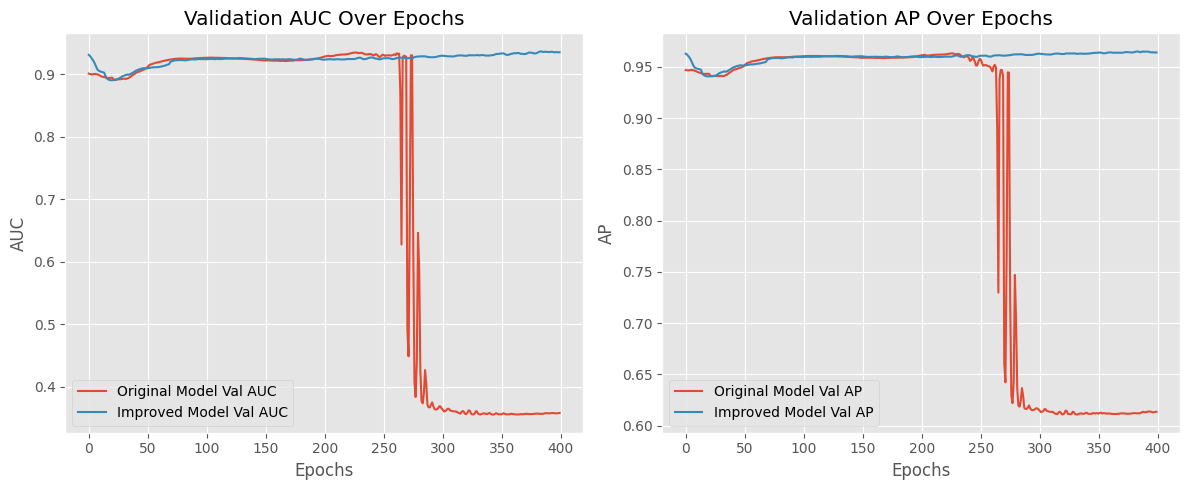

In [ ]:
# ===================================================================
# Cellule 6 : Visualisation des métriques de validation
# ===================================================================
# Cette cellule permet de visualiser l'évolution des métriques AUC et AP
# sur l'ensemble de validation au fil des époques. C'est un excellent moyen
# de comparer la vitesse d'apprentissage et la stabilité des deux modèles.

# Plotting AUC and AP
plt.figure(figsize=(12, 5))

# --- Graphique de l'AUC de validation ---
plt.subplot(1, 2, 1)
plt.plot(val_auc_history_orig, label='AUC Validation (Modèle Original)')
plt.plot(val_auc_history_imp, label='AUC Validation (Modèle Amélioré)')
plt.title('Évolution de l\'AUC de validation')
plt.xlabel('Époques')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

# --- Graphique de l'AP de validation ---
plt.subplot(1, 2, 2)
plt.plot(val_ap_history_orig, label='AP Validation (Modèle Original)')
plt.plot(val_ap_history_imp, label='AP Validation (Modèle Amélioré)')
plt.title('Évolution de l\'AP de validation')
plt.xlabel('Époques')
plt.ylabel('Average Precision (AP)')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajuste automatiquement les graphiques pour éviter les superpositions
plt.show()



--- Top 10 IPs suspectes (Modèle GAE Original) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,conn_freq,ua_diversity,score_orig,score_imp
node_id,,,,,,,,,
a45474bec36d7a99be722ac222accb0ce4033ba9a161320f77188c8418d8fd37,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819573,0.840094
14cc25e1bb7935b6bed6c4fe91eacdee58eace9874d74a12ee8415c00ca76e29,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819559,0.840231
34e20525b3ef432b70bc995f18354305af797eeac38c1a9cccf69bd1a1f83000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819326,0.841614
93fa07951bed250f6bb3e8fa7555475fa2bcdd9eb9568fd891b3073bd062efec,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.818879,0.843180
deb36c45591fff57c9fa8df5c16bb95d94c9d47ddd42e019f2fee62ffd93f0d9,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.818874,0.843201
6e3b113931370e9f97dc454dbad788a3720b3e1b8a477a533309a251c32b4f5c,0.0,0.0,0.000308,0.0,0.0,0.871120,0.0,0.801116,0.867647
4712a2b552987fd33a167672462d43739b7626f3309918dd3779f835873c17c4,0.0,0.0,0.000308,0.0,0.0,0.825136,0.0,0.789839,0.861579
baa73f3931d5033ab27c8089cd37f8569eba77c7bd02fa35cce888969a5abcd0,0.0,0.0,0.000308,0.0,0.0,0.819526,0.0,0.788809,0.759953
a6ae2f83027baa965079760dc87b2a22c78a9c2b742bb90dd4d05f5136ba2b67,0.0,0.0,0.000308,0.0,0.0,0.811763,0.0,0.786489,0.860354



--- Top 10 IPs suspectes (Modèle GAE Amélioré) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,conn_freq,ua_diversity,score_orig,score_imp
node_id,,,,,,,,,
6e3b113931370e9f97dc454dbad788a3720b3e1b8a477a533309a251c32b4f5c,0.0,0.0,0.000308,0.0,0.0,0.871120,0.0,0.801116,0.867647
4712a2b552987fd33a167672462d43739b7626f3309918dd3779f835873c17c4,0.0,0.0,0.000308,0.0,0.0,0.825136,0.0,0.789839,0.861579
a6ae2f83027baa965079760dc87b2a22c78a9c2b742bb90dd4d05f5136ba2b67,0.0,0.0,0.000308,0.0,0.0,0.811763,0.0,0.786489,0.860354
2c607a0d42e25f068905ebefcd18dd17ed8870722a6e54eca8593a72a7e34a9a,0.0,0.0,0.000308,0.0,0.0,0.692471,0.0,0.752306,0.843508
deb36c45591fff57c9fa8df5c16bb95d94c9d47ddd42e019f2fee62ffd93f0d9,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.818874,0.843201
93fa07951bed250f6bb3e8fa7555475fa2bcdd9eb9568fd891b3073bd062efec,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.818879,0.843180
34e20525b3ef432b70bc995f18354305af797eeac38c1a9cccf69bd1a1f83000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819326,0.841614
14cc25e1bb7935b6bed6c4fe91eacdee58eace9874d74a12ee8415c00ca76e29,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819559,0.840231
a45474bec36d7a99be722ac222accb0ce4033ba9a161320f77188c8418d8fd37,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.819573,0.840094


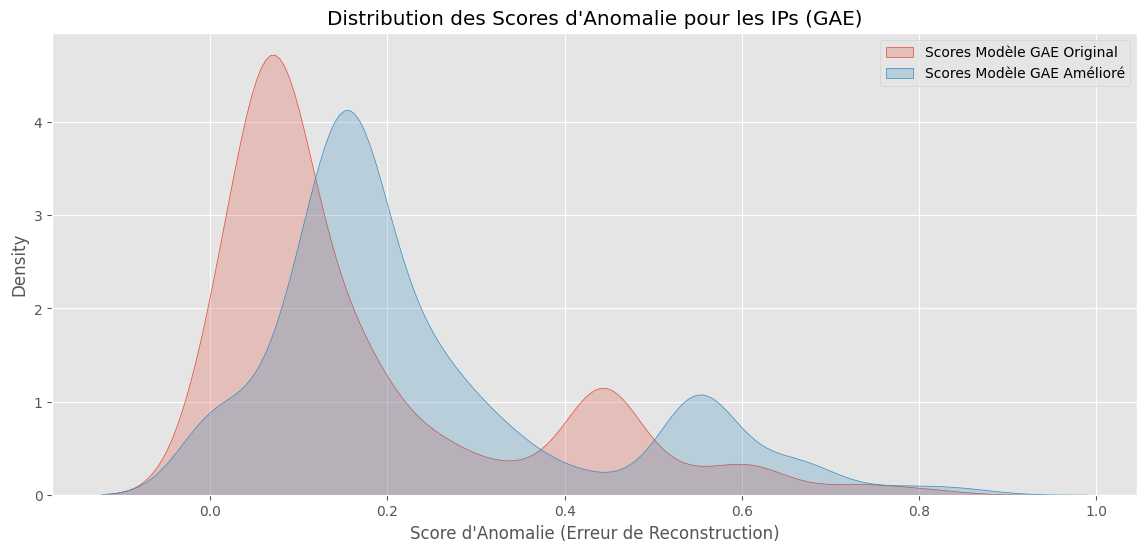

In [ ]:
# =====================================================================
# Cellule 7 : Détection d'anomalies et analyse - (MODIFIÉE pour GAE)
# =====================================================================
# L'objectif principal de ce modèle est de détecter des anomalies. Cette cellule
# définit une fonction pour calculer un score d'anomalie pour chaque nœud.
# L'hypothèse est qu'un nœud impliqué dans des activités anormales sera mal
# reconstruit par le modèle, qui a été entraîné sur des liaisons "normales".

def get_anomaly_scores(model, data_split_obj, full_edge_index):
    """Calcule les erreurs de reconstruction pour tous les nœuds avec un modèle GAE."""
    model.eval() # Mode évaluation
    with torch.no_grad():
        # On encode les données pour obtenir les embeddings z.
        # On utilise les arêtes d'entraînement pour l'encodage, car c'est ce que le modèle connaît.
        z = model.encode(data_split_obj.x, data_split_obj.train_pos_edge_index)
        
        # --- Calcul de l'erreur de reconstruction ---
        # Le décodeur par défaut effectue un produit scalaire entre les embeddings.
        # On le reproduit ici pour obtenir une matrice d'adjacence reconstruite.
        # La fonction sigmoïde transforme les scores en probabilités d'existence d'arêtes.
        adj_recon = torch.sigmoid(torch.matmul(z, z.t()))
        
        # L'erreur pour une arête (i, j) est 1 - P(arête existe).
        # Plus la probabilité est faible, plus l'erreur est grande.
        recon_error_matrix = 1 - adj_recon
        
        # On calcule l'erreur de reconstruction pour chaque nœud.
        # Une approche simple est de sommer les erreurs de toutes ses arêtes.
        node_errors = torch.zeros(data_split_obj.num_nodes, device=device)
        row, col = full_edge_index # On utilise TOUTES les arêtes originales pour le calcul du score
        
        # On récupère les erreurs pour chaque arête existante dans le graphe original
        edge_errors = recon_error_matrix[row, col]
        
        # On accumule les erreurs pour chaque nœud impliqué dans une arête.
        node_errors.scatter_add_(0, row, edge_errors)
        node_errors.scatter_add_(0, col, edge_errors)
        
        # On normalise le score par le degré du nœud pour ne pas pénaliser les nœuds très connectés.
        degrees = torch.bincount(row, minlength=data_split_obj.num_nodes) + torch.bincount(col, minlength=data_split_obj.num_nodes)
        node_errors /= degrees.clamp(min=1) # clamp(min=1) pour éviter la division par zéro
        
    return node_errors.cpu().numpy()

# --- Calcul et analyse des scores ---
# On calcule les scores pour les deux modèles.
scores_orig = get_anomaly_scores(model_orig, data_split, original_edge_index)
scores_imp = get_anomaly_scores(model_improved, data_split, original_edge_index)

# On ajoute les scores au DataFrame pour une analyse facile.
anomaly_df = node_features_df.copy()
anomaly_df['score_orig'] = scores_orig
anomaly_df['score_imp'] = scores_imp

# On se concentre sur les adresses IP, car ce sont elles qui initient les connexions suspectes.
ip_anomaly_df = anomaly_df[anomaly_df['is_ip'] > 0.5].copy()

# Colonnes pertinentes à afficher pour comprendre pourquoi une IP est anormale.
cols_to_display = [
    'failure_rate', 'degree', 'total_attempts', 
    'num_countries', 'num_cities',
    'conn_freq', 'ua_diversity', # Caractéristiques comportementales
    'score_orig', 'score_imp'
]

# --- Affichage des résultats ---
print("\n--- Top 10 IPs suspectes (Modèle GAE Original) ---")
display(ip_anomaly_df.sort_values('score_orig', ascending=False).head(10)[cols_to_display])

print("\n--- Top 10 IPs suspectes (Modèle GAE Amélioré) ---")
display(ip_anomaly_df.sort_values('score_imp', ascending=False).head(10)[cols_to_display])

# --- Visualisation de la distribution des scores ---
# Un graphique de densité (KDE) permet de voir la forme de la distribution des scores.
# Idéalement, on verrait une distribution principale pour les nœuds normaux et une "queue" pour les anomalies.
plt.figure(figsize=(14, 6))
sns.kdeplot(ip_anomaly_df['score_orig'], label='Scores Modèle GAE Original', fill=True)
sns.kdeplot(ip_anomaly_df['score_imp'], label='Scores Modèle GAE Amélioré', fill=True)
plt.title("Distribution des Scores d'Anomalie pour les IPs (GAE)")
plt.xlabel("Score d'Anomalie (Erreur de Reconstruction)")
plt.legend()
plt.show()

Calcul de t-SNE pour 'Espace Latent t-SNE - GAE Original'...


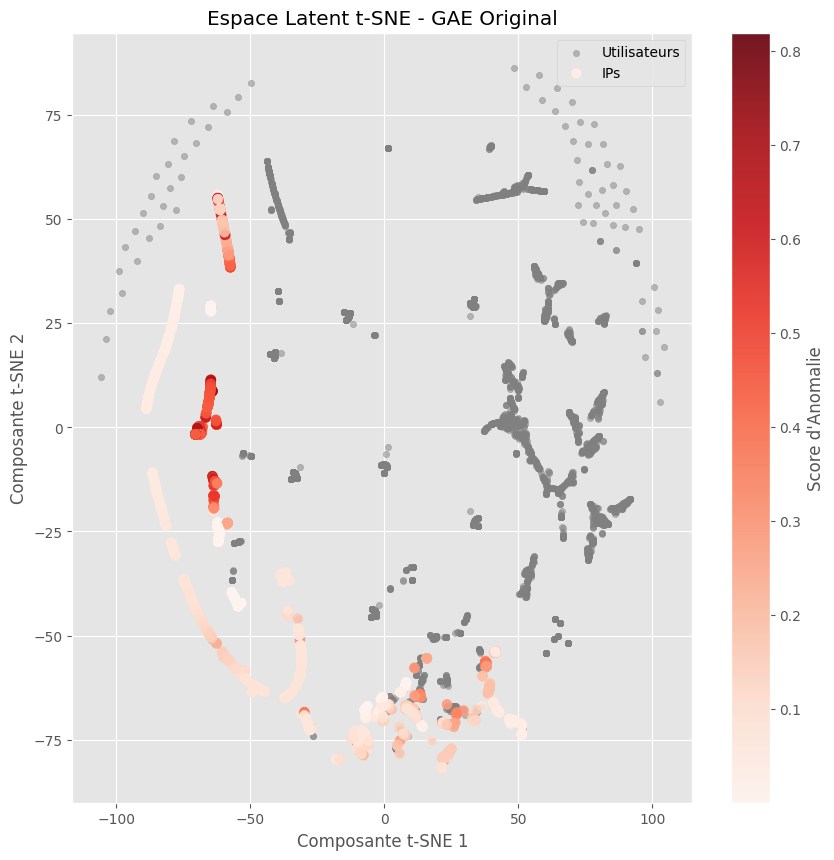

Calcul de t-SNE pour 'Espace Latent t-SNE - GAE Amélioré'...


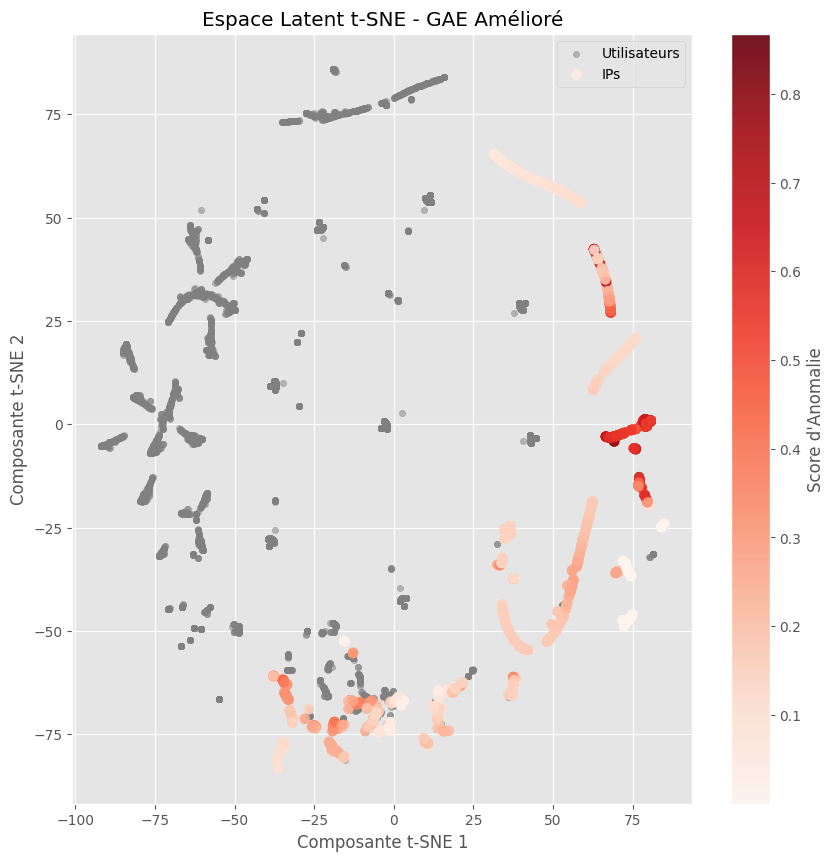

In [ ]:
# =====================================================================
# Cellule 8 : Visualisation T-SNE des Espaces Latents - (MODIFIÉE pour GAE)
# =====================================================================
# t-SNE est un algorithme de réduction de dimensionnalité qui permet de visualiser
# des données de grande dimension (comme nos embeddings z de dimension 64) en 2D.
# Cela nous aide à comprendre intuitivement la structure que le modèle a apprise.

def visualize_tsne(model, data_split_obj, full_edge_index, title):
    """Génère et affiche une visualisation t-SNE de l'espace latent pour un GAE."""
    model.eval()
    with torch.no_grad():
        # On génère les embeddings z à partir du modèle.
        z = model.encode(data_split_obj.x, data_split_obj.train_pos_edge_index)
        z = z.cpu().numpy() # On passe sur CPU et convertit en array numpy pour scikit-learn
        
    # --- Application de t-SNE ---
    print(f"Calcul de t-SNE pour '{title}'...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    z_tsne = tsne.fit_transform(z)
    
    # --- Préparation pour la visualisation ---
    # On identifie quels nœuds sont des IPs et lesquels sont des utilisateurs.
    is_ip = data_split_obj.x[:, 0].cpu().numpy() > 0.5
    
    plt.figure(figsize=(10, 10))
    # On affiche les utilisateurs en gris et en arrière-plan pour ne pas surcharger le visuel.
    plt.scatter(z_tsne[~is_ip, 0], z_tsne[~is_ip, 1], s=20, color='gray', alpha=0.5, label='Utilisateurs')
    
    # On colore les points des IPs en fonction de leur score d'anomalie.
    # Cela permet de voir si les IPs considérées comme anormales se regroupent dans l'espace latent.
    ip_scores = get_anomaly_scores(model, data_split_obj, full_edge_index)[is_ip]
    scatter = plt.scatter(z_tsne[is_ip, 0], z_tsne[is_ip, 1], s=50, c=ip_scores, cmap='Reds', alpha=0.9, label='IPs')
    
    plt.title(title)
    plt.xlabel("Composante t-SNE 1")
    plt.ylabel("Composante t-SNE 2")
    plt.legend()
    # Ajout d'une barre de couleur pour interpréter les couleurs des scores.
    cbar = plt.colorbar(scatter)
    cbar.set_label("Score d'Anomalie")
    plt.show()

# --- Génération des visualisations pour les deux modèles ---
visualize_tsne(model_orig, data_split, original_edge_index, "Espace Latent t-SNE - GAE Original")
visualize_tsne(model_improved, data_split, original_edge_index, "Espace Latent t-SNE - GAE Amélioré")

In [ ]:
# ===================================================================
# Cellule 9 : Sauvegarde des résultats et du meilleur modèle (v4)
# ===================================================================
# Cette cellule a pour but de sauvegarder les artefacts importants de notre expérience :
# 1. Le modèle le plus performant.
# 2. Un tableau comparatif des performances.
# 3. La liste des anomalies les plus importantes détectées.

import os
import pandas as pd

# On définit un répertoire de sortie pour garder les résultats organisés.
results_dir = "results_v4_behavioral"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# --- 1. Sauvegarder le meilleur modèle ---
# On choisit le meilleur modèle en se basant sur la métrique "Average Precision" (AP) sur l'ensemble de test.
# L'AP est souvent plus informative que l'AUC sur des données déséquilibrées (ce qui est le cas ici).
best_model = model_improved if test_ap_imp > test_ap_orig else model_orig
model_name = "gae_improved" if test_ap_imp > test_ap_orig else "gae_original"
model_path = os.path.join(results_dir, f"best_model_{model_name}.pt")

# On sauvegarde uniquement les poids du modèle (`state_dict`), ce qui est plus léger et plus portable.
torch.save(best_model.state_dict(), model_path)
print(f"Meilleur modèle ('{model_name}') sauvegardé dans : {model_path}")

# --- 2. Sauvegarder le tableau de comparaison ---
# On crée un DataFrame pandas pour présenter clairement les résultats des tests.
results_data = {
    "Model": ["Original GAE", "Improved GAE"],
    "Test AUC": [test_auc_orig, test_auc_imp],
    "Test AP": [test_ap_orig, test_ap_imp]
}
results_df = pd.DataFrame(results_data)

# On sauvegarde ce DataFrame en fichier CSV.
comparison_path = os.path.join(results_dir, "model_comparison.csv")
results_df.to_csv(comparison_path, index=False)
print(f"Tableau de comparaison sauvegardé dans : {comparison_path}")

# --- 3. Sauvegarder la liste des IPs les plus suspectes ---
# On utilise le DataFrame des anomalies calculé précédemment et on le trie
# en fonction des scores du meilleur modèle pour identifier les IPs les plus anormales.
top_anomalies_path = os.path.join(results_dir, "top_anomalies.csv")

# On sélectionne la bonne colonne de score en fonction du meilleur modèle.
best_score_col = 'score_imp' if test_ap_imp > test_ap_orig else 'score_orig'
# On trie et on sauvegarde les 100 IPs avec le score le plus élevé.
ip_anomaly_df.sort_values(best_score_col, ascending=False).head(100).to_csv(top_anomalies_path)
print(f"Top 100 des IPs suspectes sauvegardées dans : {top_anomalies_path}")

Meilleur modèle ('gae_improved') sauvegardé dans : results_v4_behavioral/best_model_gae_improved.pt
Tableau de comparaison sauvegardé dans : results_v4_behavioral/model_comparison.csv
Top 100 des IPs suspectes sauvegardées dans : results_v4_behavioral/top_anomalies.csv


/Users/ismail/PING14/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ismail/PING14/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters found by HDBSCAN: 112
Average silhouette score: 0.91
Average silhouette score: 0.91
Number of density outliers: 1602
Number of silhouette outliers: 148
Total number of anomalies: 1750
Number of density outliers: 1602
Number of silhouette outliers: 148
Total number of anomalies: 1750


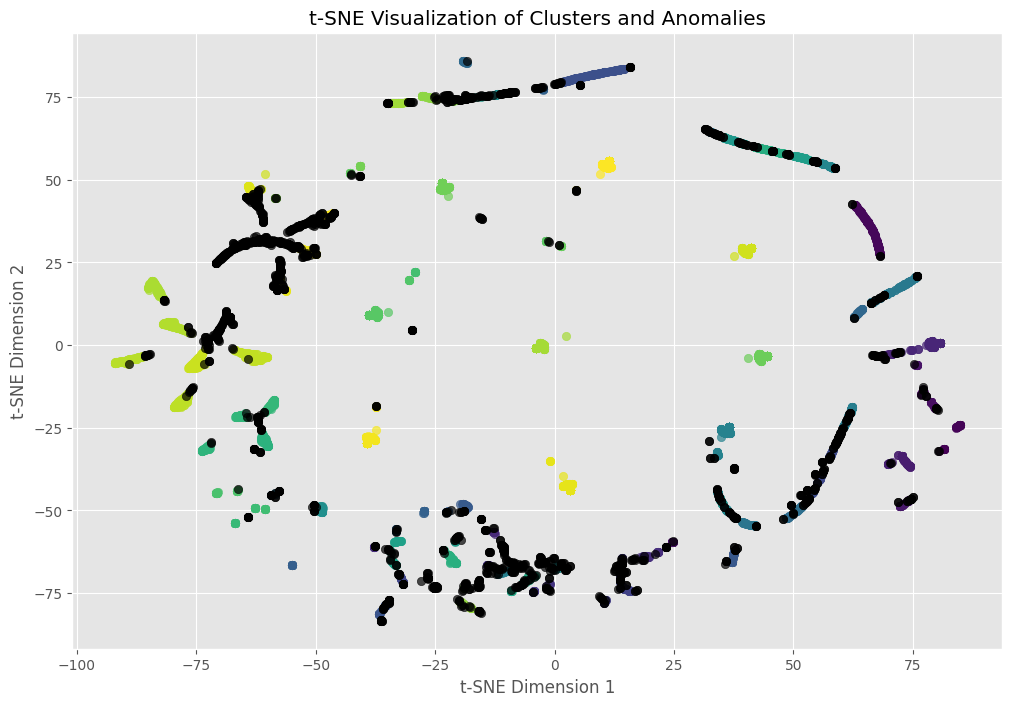

In [23]:
import hdbscan
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Get the latent space embeddings
with torch.no_grad():
    z = best_model.encode(data.x, original_edge_index.to(torch.long))

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(z.cpu())

# Get the number of clusters (excluding noise)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters found by HDBSCAN: {n_clusters}')

# Calculate silhouette scores for clustered points
if n_clusters > 1:
    silhouette_avg = silhouette_score(z.cpu()[cluster_labels != -1], cluster_labels[cluster_labels != -1])
    print(f'Average silhouette score: {silhouette_avg:.2f}')
    
    silhouette_vals = silhouette_samples(z.cpu(), cluster_labels)
    
    # Identify outliers based on silhouette score
    silhouette_threshold = 0.1
    silhouette_outliers = (cluster_labels != -1) & (silhouette_vals < silhouette_threshold)
else:
    silhouette_outliers = np.zeros_like(cluster_labels, dtype=bool)

# Combine density outliers and silhouette outliers
density_outliers = cluster_labels == -1
final_outlier_mask = density_outliers | silhouette_outliers

print(f'Number of density outliers: {np.sum(density_outliers)}')
print(f'Number of silhouette outliers: {np.sum(silhouette_outliers)}')
print(f'Total number of anomalies: {np.sum(final_outlier_mask)}')

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z_tsne = tsne.fit_transform(z.cpu())

# Plot the results
plt.figure(figsize=(12, 8))

# Plot normal points with cluster colors
normal_points_mask = ~final_outlier_mask
normal_labels = cluster_labels[normal_points_mask]
normal_tsne = z_tsne[normal_points_mask]

unique_labels = set(normal_labels)
# Filter out noise label if present, as they are outliers
if -1 in unique_labels:
    unique_labels.remove(-1)

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    cluster_points = (normal_labels == k)
    plt.scatter(normal_tsne[cluster_points, 0], normal_tsne[cluster_points, 1],
                c=[col], label=f'Cluster {k}', alpha=0.7)

# Plot anomalies in black
plt.scatter(z_tsne[final_outlier_mask, 0], z_tsne[final_outlier_mask, 1], label='Anomaly', c='black', alpha=0.7)

plt.title('t-SNE Visualization of Clusters and Anomalies')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
#plt.legend()
plt.grid(True)
plt.show()